# Analysis 1

### Lauren Lunsford, Ye Chan Kim, Christopher Peña 
#### Date Started: February 3, 2022
#### Last Updated: February 4, 2022

**Notable Things:**
 
- Cold Chain items appear to take less time to pack than non-cold chain times.  Why? Does this stay true across multiple days? Is there a separate line for CC items? 

**Questions:** 
- Should we use NaN or None?
- How to factor in qty. Does the qty 

In [1]:
#importing packages
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt


## 1. Loading and Viewing Data

In [2]:
time_stamps_lst = ["TIMESTAMP_UTC","PICK_TIMESTAMP_LOCAL","BOXINTIME",
                   "DELIVERYDATE","BOXOUTTIME","PICKCOMPLETETIME","PICKORDERSUBMITTIME",
                   "PICKORDERSTARTTIME","PICKORDERENDTIME"]

wd='UMich_Sample_Data/'
b=pd.read_csv(wd+'UMich-SampleData-PicksMadePNW-Jan3.csv', parse_dates = time_stamps_lst)

Note:
- TIMESTAMP_UTC appears to be whenever that record was made.
- BOXIN/BOXOUT are when the order was started/completed
- PICKORDER…. Appears to be the same as BOXIN/BOXOUT
- PICKCOMPLETE is when the button was pressed
- PICKORDERSUBMITTIME is when the order was uploaded to the server
- PICKORDERENDTIME is when the full order was completed (if >1 box, when all boxes are completed)

### 1.2 Picks Made PNW Jan3


In [3]:
b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99215 entries, 0 to 99214
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   FC_NAME               99215 non-null  object        
 1   TIMESTAMP_UTC         99215 non-null  datetime64[ns]
 2   PICK_TIMESTAMP_LOCAL  99215 non-null  datetime64[ns]
 3   BOXLINEID             99215 non-null  int64         
 4   PICKLINEID            99215 non-null  int64         
 5   QTY                   99215 non-null  float64       
 6   PICKLINEPICKEDQTY     99215 non-null  float64       
 7   BOXID                 99215 non-null  int64         
 8   BOXBARCODE            99215 non-null  object        
 9   BOXINTIME             99215 non-null  datetime64[ns]
 10  BOXOUTTIME            98979 non-null  datetime64[ns]
 11  ORDER_ID              99215 non-null  object        
 12  DELIVERYDATE          99215 non-null  datetime64[ns]
 13  DOUBLECHECKMESSA

In [4]:
b.head()

,FC_NAME,TIMESTAMP_UTC,PICK_TIMESTAMP_LOCAL,BOXLINEID,PICKLINEID,QTY,PICKLINEPICKEDQTY,BOXID,BOXBARCODE,BOXINTIME,...,ZONENAME,SHELF,LEVEL,PICKS_DELETED,BOX_LINES_DELETED,BOXES_DELETED,BOX_EXTRA_DELETED,PICK_EXTRA_DELETED,PICK_ORDER_DELETED,LOC_DELETED
0,Pacific Northwest,2022-01-03 03:04:42,2022-01-02 19:04:42,55389552,56434667,1.0,1.0,2574427,PRO_5e941c19-2aff-4eb6-a21f-34acd993b4eb,2022-01-02 17:05:40,...,Zone 01,F,3,True,True,True,True,True,True,False
1,Pacific Northwest,2022-01-03 03:04:54,2022-01-02 19:04:54,55389562,56434668,1.0,1.0,2574427,PRO_5e941c19-2aff-4eb6-a21f-34acd993b4eb,2022-01-02 17:05:40,...,Zone 01,C,7,True,True,True,True,True,True,False
2,Pacific Northwest,2022-01-03 03:05:08,2022-01-02 19:05:08,55389578,56434537,1.0,1.0,2574420,PRO_1a46b756-dc79-425d-bb23-bc816d74588d,2022-01-02 17:05:39,...,Zone 01,E,7,True,True,True,True,True,True,False
3,Pacific Northwest,2022-01-03 03:05:11,2022-01-02 19:05:11,55389580,56434536,1.0,1.0,2574420,PRO_1a46b756-dc79-425d-bb23-bc816d74588d,2022-01-02 17:05:39,...,Zone 01,B,6,True,True,True,True,True,True,False
4,Pacific Northwest,2022-01-03 03:05:24,2022-01-02 19:05:24,55389596,56434253,1.0,1.0,2574402,PRO_0ecbae76-5c71-447b-9810-1c665ba77520,2022-01-02 17:05:35,...,Zone 01,A,4,True,True,True,True,True,True,False


## 2. Analysis 1: unit hours per product packed

In [5]:
df=b[["BOXINTIME",'BOXOUTTIME','PICKCOMPLETETIME','BOXBARCODE','PRODUCTNAME',"QTY"]]
display(df.head(5))
display(df.info())

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,QTY
0,2022-01-02 17:05:40,2022-01-02 19:10:21,2022-01-02 19:04:42,PRO_5e941c19-2aff-4eb6-a21f-34acd993b4eb,PNW-CCPLENTRL2HALF,1.0
1,2022-01-02 17:05:40,2022-01-02 19:10:21,2022-01-02 19:04:54,PRO_5e941c19-2aff-4eb6-a21f-34acd993b4eb,PNW-CCPLEVAN5CHZRAV,1.0
2,2022-01-02 17:05:39,2022-01-02 19:10:30,2022-01-02 19:05:08,PRO_1a46b756-dc79-425d-bb23-bc816d74588d,PNW-CCPLETRUCHXITAL,1.0
3,2022-01-02 17:05:39,2022-01-02 19:10:30,2022-01-02 19:05:11,PRO_1a46b756-dc79-425d-bb23-bc816d74588d,PNW-CCCOOKVENTENDER,1.0
4,2022-01-02 17:05:35,2022-01-02 19:10:49,2022-01-02 19:05:24,PRO_0ecbae76-5c71-447b-9810-1c665ba77520,PNW-5548,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99215 entries, 0 to 99214
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BOXINTIME         99215 non-null  datetime64[ns]
 1   BOXOUTTIME        98979 non-null  datetime64[ns]
 2   PICKCOMPLETETIME  99213 non-null  datetime64[ns]
 3   BOXBARCODE        99215 non-null  object        
 4   PRODUCTNAME       99215 non-null  object        
 5   QTY               99215 non-null  float64       
dtypes: datetime64[ns](3), float64(1), object(2)
memory usage: 4.5+ MB


None

In [6]:
df.shape

(99215, 6)

In [7]:
display(df.shape)

display(df.isna().sum())

#remove na entries for PICKCOMPLETETIME
df.dropna(subset = ["PICKCOMPLETETIME"], inplace = True)

display(df.isna().sum())

display(df.shape)

(99215, 6)

BOXINTIME             0
BOXOUTTIME          236
PICKCOMPLETETIME      2
BOXBARCODE            0
PRODUCTNAME           0
QTY                   0
dtype: int64

BOXINTIME             0
BOXOUTTIME          234
PICKCOMPLETETIME      0
BOXBARCODE            0
PRODUCTNAME           0
QTY                   0
dtype: int64

(99213, 6)

In [8]:
df[df.BOXBARCODE.str.startswith("PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A")].sort_values(by = "PICKCOMPLETETIME", 
                                                                                           ascending= True)

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,QTY
59033,2022-01-02 19:22:26,NaT,2022-01-04 06:42:28,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-CCIFGRNDBEEF90,2.0
99159,2022-01-02 19:22:26,NaT,2022-01-04 06:42:28,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-CCIFGRNDBEEF90,2.0
59233,2022-01-02 19:22:26,NaT,2022-01-04 06:43:10,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-PLECENTOALLIN,2.0
99160,2022-01-02 19:22:26,NaT,2022-01-04 06:43:10,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-PLECENTOALLIN,2.0
59216,2022-01-02 19:22:26,NaT,2022-01-04 06:43:25,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-PLEAFBTPITABRD,1.0
99161,2022-01-02 19:22:26,NaT,2022-01-04 06:43:25,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-PLEAFBTPITABRD,1.0
59339,2022-01-02 19:22:26,NaT,2022-01-04 07:11:54,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-CCPLEIPCHXBRST,2.0
99162,2022-01-02 19:22:26,NaT,2022-01-04 07:11:54,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-CCPLEIPCHXBRST,2.0
59422,2022-01-02 19:22:26,NaT,2022-01-04 07:12:38,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-PLEIMPDRIEDMANG,1.0
99163,2022-01-02 19:22:26,NaT,2022-01-04 07:12:38,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_A,PNW-PLEIMPDRIEDMANG,1.0


In [9]:
df[df.BOXBARCODE.str.startswith("PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B")].sort_values(by = "PICKCOMPLETETIME", 
                                                                                           ascending= True)

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,QTY
59050,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:24:46,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-32164,1.0
59292,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:26:51,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-32984,2.0
59303,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:26:53,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-21075,1.0
59483,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:28:21,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-5212,1.0
59572,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:29:03,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-6240,3.0
59591,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:29:13,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-32421,1.0
59768,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:30:34,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-5463,1.0
60195,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:33:37,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-6281,1.0
60207,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:33:41,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-6276,1.0
60314,2022-01-02 19:22:26,2022-01-03 13:36:27,2022-01-03 13:34:25,PRO_49f01562-6c35-4dce-89e6-f9ffdeb5f294_B,PNW-32063,1.0


In [10]:
# because when duplicated item exist, the second item takes 0 seconds to pickup, 
# drop all the duplicates (need to disccus)

# sort by BOXCODE, PICKUPTIME
df_sorted = df.sort_values(by = ["BOXBARCODE","PICKCOMPLETETIME"], ascending= True).copy()
df_dup_drop = df_sorted.drop_duplicates(subset=["BOXBARCODE","PRODUCTNAME"], keep="last")
display(df_dup_drop.shape)
display(df_dup_drop)

(99144, 6)

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,QTY
25820,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:01,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31778,1.0
25855,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:13,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31735,1.0
25891,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:28,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-PLESGPSPTOMARN,1.0
26002,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:14,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-CCPLECAPRALAMB,1.0
26043,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:30,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31692,1.0
...,...,...,...,...,...,...
60917,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:38:41,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-5163,1.0
61010,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:19,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-31629,1.0
61017,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:22,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-5219,1.0
61035,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:28,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-DLSTRAWLICORICE,1.0


In [11]:
99213-99144

69

In [12]:
#confirming the above function
dup_counter = 0
for i in tqdm(range(1,df_sorted.reset_index(drop = True).shape[0])):
    if ((df_sorted.iloc[i]["BOXBARCODE"] == df_sorted.iloc[i-1]["BOXBARCODE"]) & 
       (df_sorted.iloc[i]["PRODUCTNAME"] == df_sorted.iloc[i-1]["PRODUCTNAME"])):
        dup_counter += 1
        
print(dup_counter)

100%|██████████| 99212/99212 [00:47<00:00, 2092.41it/s]

69


In [13]:
df_dup_drop.head()

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,QTY
25820,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:01,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31778,1.0
25855,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:13,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31735,1.0
25891,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:28,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-PLESGPSPTOMARN,1.0
26002,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:14,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-CCPLECAPRALAMB,1.0
26043,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:30,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31692,1.0


In [14]:
df_grouped = df_dup_drop.groupby(by = "BOXBARCODE")
#save in another dict to modify the inner df
df_grouped_dict = {i[0]:i[1] for i in df_grouped}

#get time dff = pickup time 
for key,df in df_grouped_dict.items():
    df.insert(5,"PICKTIME_SEC",df.PICKCOMPLETETIME.diff().dt.total_seconds())

In [15]:
len(df_grouped_dict)

7188

In [16]:
from collections import defaultdict

#check nan
def isNaN(num):
    return num!= num

item_time_dict = defaultdict(list)

for df in df_grouped_dict.values():
    for index,row in df.iterrows():
        if isNaN(row.PICKTIME_SEC):
            pass
        else:
            item_time_dict[row.PRODUCTNAME].append(row.PICKTIME_SEC)
        
    

In [17]:
item_time_df = pd.DataFrame(columns = ["ITEM","TIME_LIST"])
item_time_df

,ITEM,TIME_LIST


In [18]:
item_time_df = pd.DataFrame(columns = ["ITEM","TIME_LIST"])

ITEM = item_time_dict.keys()
TIME_LIST = item_time_dict.values()
item_time_df["ITEM"] = ITEM
item_time_df["TIME_LIST"] = TIME_LIST

item_time_df["Mean"] = item_time_df.TIME_LIST.apply(np.median)
item_time_df

,ITEM,TIME_LIST,Mean
0,PNW-31735,"[12.0, 18.0, 93.0, 23.0, 14.0, 25.0, 2.0, 14.0...",26.0
1,PNW-PLESGPSPTOMARN,"[15.000000000000002, 27.0, 11.0, 5.0, 3.0, 13....",10.0
2,PNW-CCPLECAPRALAMB,"[46.0, 15.000000000000002, 20.0, 4.0, 89.0, 4....",7.0
3,PNW-31692,"[16.0, 123.00000000000001, 77.0, 260.0, 62.000...",44.0
4,PNW-5463,"[7.0, 14.0, 19.0, 6.0, 26.0, 7.0, 11.0, 2.0, 1...",18.0
...,...,...,...
676,PNW-TPADSWINGREGDAY,"[4.0, 21.0, 4.0, 3145.0, 4.0, 55.0, 3.0]",4.0
677,PNW-SKBFORGROOTS,"[39.0, 8.0, 219.0, 128.0, 4.0, 10.0, 31.000000...",16.5
678,PNW-SKGFBFKLSWPOTAT,"[2.0, 58.00000000000001, 56.0, 11.0, 5.0, 6.0,...",8.5
679,PNW-SKBFORGSQUASHES,"[4.0, 3.0, 143.0, 9.0, 3.0, 4.0]",4.0


In [19]:
item_time_df_CC=item_time_df[item_time_df['ITEM'].str[0:6]=='PNW-CC']
item_time_df_NOT_CC=item_time_df[item_time_df['ITEM'].str[0:6]!='PNW-CC']
print(np.mean(item_time_df_CC['Mean']),np.mean(item_time_df_NOT_CC['Mean']))

11.763736263736265 19.4375


In [20]:
item_time_df_CC['ITEM'].head(20)

2      PNW-CCPLECAPRALAMB
5      PNW-CCIFOGPASTEGGS
15     PNW-CCNNCYOGWHLPLN
16     PNW-CCPLEIPCHXBRST
34    PNW-CCIFCHLNSEABASS
38    PNW-CCDLCTTPINAPPSP
39    PNW-CCCCOGCTGCHEESE
40    PNW-CCIFSHREDMEXCHE
41    PNW-CCPPOGDKCHOCPUD
55    PNW-CCBELSLICEDMOZZ
56       PNW-CCIFMAHIMAHI
57    PNW-CCIFSHARPCHEDCH
58     PNW-CCCOOKVENPARTY
61    PNW-CCPLEODYCRFETAC
68    PNW-CCPLECALUNSOATM
72    PNW-CCPLEIFGF85GRBF
73    PNW-CCRCORGLVGGOUDA
74    PNW-CCIFGFWHOMILKGY
75    PNW-CCCVPRHERCHX3.5
76    PNW-CCPLEFRTRIBEY10
Name: ITEM, dtype: object

In [21]:
item_time_df.sort_values(by = "Mean", ascending=False)

,ITEM,TIME_LIST,Mean
500,PNW-MAYKTIKAMASSAUC,"[68.0, 3.0, 135.0, 47.0, 26.0, 52.0, 159.0, 37...",80.0
600,PNW-IFALMONDSHROIL,"[138.0, 22.0, 42.0, 4.0, 12.0, 16.0, 49.0, 6.0...",79.5
62,PNW-6302,"[99.0, 60.00000000000001, 15.000000000000002, ...",79.0
85,PNW-5379,"[32.0, 93.0, 135.0, 44.0, 57.0, 3.0, 33.0, 147...",71.0
674,PNW-SKPFOFRCKPSCART,"[106.0, 7.0, 29.000000000000004, 1318.0, 4.0, ...",67.5
...,...,...,...
88,PNW-32164,"[2.0, 1.0, 3.0, 4.0, 3.0, 4.0, 3.0, 6.0, 7.0, ...",3.0
264,PNW-SOGBLUEBOONCOFF,"[0.0, 4.0, 3.0, 5.0, 2.0, 3.0, 4.0, 2.0, 3.0, ...",3.0
99,PNW-CCPLENTRLWHOLE,"[2.0, 6.0, 6.0, 1.0, 3.0, 4.0, 1.0, 3.0, 4.0, ...",3.0
309,PNW-CCIFNORSMOKSALM,"[2.0, 3.0, 3.0, 5.0, 12.0, 2.0, 1.0, 3.0, 4.0,...",3.0


In [22]:
print( len(product_time_averages), len(b['PRODUCTNAME'].unique()))
print("Need to find the 2 values. My guess is they're both ")

NameError: name 'product_time_averages' is not defined

### 2.5 Cold Chain times

Calculating cost of CC items includes:
   
   - Time to pack
   - How much of the item you can fit into a box before you need to add the extra packaging (so packaging cost / %space of box it takes up)

In [ ]:
CC_product_time_averages=[]
for item in product_time_averages:
    if item[0][4:6]=='CC':
        CC_product_time_averages.append(item)

In [ ]:
CC_product_time_averages

## 3. Exploration of Results

### 3. A) Value Distribution

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(ptimes, bins=50)

There's a fun little logistic distribution

### 3. B) Correlation Matrix

Need: ZONENAME	SHELF	LEVEL for each product

In [264]:
df_zone=b[["BOXINTIME",'BOXOUTTIME','PICKCOMPLETETIME','BOXBARCODE','PRODUCTNAME',"ZONENAME","SHELF","LEVEL"]]
# sort by BOXCODE, PICKUPTIME
df_zone_sorted = df_zone.sort_values(by = ["BOXBARCODE","PICKCOMPLETETIME"], ascending= True).copy()
df_zone_dup_drop = df_zone_sorted.drop_duplicates(subset=["BOXBARCODE","PRODUCTNAME"], keep="last")
display(df_zone_dup_drop.shape)
display(df_zone_dup_drop.head())

(99146, 8)

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,ZONENAME,SHELF,LEVEL
25820,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:01,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31778,Zone 02,A,2
25855,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:13,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31735,Zone 02,C,1
25891,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:28,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-PLESGPSPTOMARN,Zone 03,G,5
26002,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:14,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-CCPLECAPRALAMB,Zone 04,D,2
26043,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:30,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31692,Zone 06,A,4


In [286]:
df_zone_dup_drop["LEVEL"] = df_zone_dup_drop["LEVEL"].astype(str)


In [288]:
df_zone_dup_drop["ZONE_SHELF_LEVEL"] = df_zone_dup_drop[['ZONENAME', 'SHELF', "LEVEL"]].agg('-'.join, axis=1)

In [289]:
df_zone_dup_drop

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,ZONENAME,SHELF,LEVEL,ZONE_SHELF_LEVEL
25820,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:01,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31778,Zone 02,A,2,Zone 02-A-2
25855,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:13,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31735,Zone 02,C,1,Zone 02-C-1
25891,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:28,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-PLESGPSPTOMARN,Zone 03,G,5,Zone 03-G-5
26002,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:14,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-CCPLECAPRALAMB,Zone 04,D,2,Zone 04-D-2
26043,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:30,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31692,Zone 06,A,4,Zone 06-A-4
...,...,...,...,...,...,...,...,...,...
60917,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:38:41,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-5163,Zone 11,A,1,Zone 11-A-1
61010,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:19,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-31629,Zone 13,A,1,Zone 13-A-1
61017,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:22,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-5219,Zone 13,A,2,Zone 13-A-2
61035,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:28,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-DLSTRAWLICORICE,Zone 13,C,7,Zone 13-C-7


In [306]:
df_zone_dup_drop["ZONE_INT"] = df_zone_dup_drop["ZONENAME"].str.split(" ").apply(lambda x:int(x[1]))
df_zone_dup_drop["SHELF_INT"] = df_zone_dup_drop["SHELF"].apply(lambda x:ord(x))
df_zone_dup_drop["LEVEL_INT"] = df_zone_dup_drop["LEVEL"].apply(lambda x:int(x))

In [307]:
df_zone_dup_drop

,BOXINTIME,BOXOUTTIME,PICKCOMPLETETIME,BOXBARCODE,PRODUCTNAME,ZONENAME,SHELF,LEVEL,ZONE_SHELF_LEVEL,ZONE_INT,SHELF_INT,LEVEL_INT
25820,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:01,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31778,Zone 02,A,2,Zone 02-A-2,2,65,2
25855,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:13,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31735,Zone 02,C,1,Zone 02-C-1,2,67,1
25891,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:58:28,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-PLESGPSPTOMARN,Zone 03,G,5,Zone 03-G-5,3,71,5
26002,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:14,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-CCPLECAPRALAMB,Zone 04,D,2,Zone 04-D-2,4,68,2
26043,2022-01-02 19:06:18,2022-01-03 08:04:17,2022-01-03 07:59:30,PRO_0009cfbc-ddaa-480d-a56e-067a390e98c7,PNW-31692,Zone 06,A,4,Zone 06-A-4,6,65,4
...,...,...,...,...,...,...,...,...,...,...,...,...
60917,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:38:41,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-5163,Zone 11,A,1,Zone 11-A-1,11,65,1
61010,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:19,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-31629,Zone 13,A,1,Zone 13-A-1,13,65,1
61017,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:22,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-5219,Zone 13,A,2,Zone 13-A-2,13,65,2
61035,2022-01-02 19:22:40,2022-01-03 13:40:07,2022-01-03 13:39:28,PRO_ffebaf4c-7cfc-4ee1-b0dc-4f07ea4ecb6f,PNW-DLSTRAWLICORICE,Zone 13,C,7,Zone 13-C-7,13,67,7


In [308]:
df_grouped = df_zone_dup_drop.groupby(by = "BOXBARCODE")
#save in another dict to modify the inner df
df_grouped_dict = {i[0]:i[1] for i in df_grouped}

#get time dff = pickup time 
for key,df in df_grouped_dict.items():
    df.insert(5,"PICKTIME_SEC",df.PICKCOMPLETETIME.diff().dt.total_seconds())

In [ ]:
zone_shelf_level_df = defaultdict([])

In [312]:
zone_shelf_level_df = defaultdict(list)
zone_df = defaultdict(list)
shelf_df = defaultdict(list)
level_df = defaultdict(list)

for df in df_grouped_dict.values():
    for index,row in df.iterrows():
        if isNaN(row.PICKTIME_SEC):
            pass
        else:
            zone_shelf_level_df[row.ZONE_SHELF_LEVEL].append(row.PICKTIME_SEC)
            zone_df[row.ZONE_INT].append(row.PICKTIME_SEC)
            shelf_df[row.SHELF_INT].append(row.PICKTIME_SEC)
            level_df[row.LEVEL_INT].append(row.PICKTIME_SEC)

In [313]:
item_time_df = pd.DataFrame(columns = ["ITEM","TIME_LIST"])

ITEM = item_time_dict.keys()
TIME_LIST = item_time_dict.values()
item_time_df["ITEM"] = ITEM
item_time_df["TIME_LIST"] = TIME_LIST

defaultdict(list,
            {1: [12.0,
              15.000000000000002,
              187.0,
              7.0,
              36.0,
              81.0,
              102.0,
              18.0,
              21.0,
              247.00000000000003,
              18.0,
              26.0,
              4.0,
              56.0,
              433.0,
              80.0,
              10.0,
              47.0,
              43.0,
              32.0,
              81.0,
              5.0,
              2.0,
              122.00000000000001,
              43.0,
              11.0,
              4.0,
              6.0,
              6.0,
              13.0,
              12.0,
              36.0,
              81.0,
              10.0,
              3.0,
              37.0,
              17.0,
              18.0,
              73.0,
              45.0,
              178.0,
              54.0,
              21.0,
              3.0,
              141.0,
              11.0,
              171.0,


(array([1.223e+04, 1.700e+01, 1.000e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00]),
 array([    0. ,  3053.8,  6107.6,  9161.4, 12215.2, 15269. , 18322.8,
        21376.6, 24430.4, 27484.2, 30538. ]),
 <BarContainer object of 10 artists>)

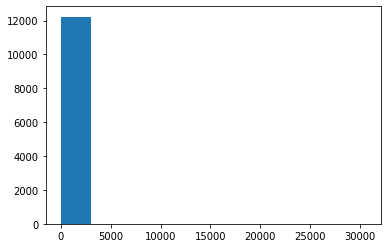

In [319]:
plt.hist(level_df[1], )


In [314]:
pd.DataFrame.from_dict(level_df, )

ValueError: All arrays must be of the same length

In [ ]:
#checking ot see if shelves, zones, and levels are the same for each product
zonenames=[]
shelves=[]
levels=[]
for product in b['PRODUCTNAME'].unique():
    x=b[b['PRODUCTNAME']==product]
    dct=x.to_dict('list')
    zonenames.append(len(set(dct['ZONENAME'])))
    shelves.append(len(set(dct['SHELF'])))
    levels.append(len(set(dct['LEVEL'])))
print(np.mean(zonenames), np.mean(shelves), np.mean(levels))


This means that the zones and shelves are constant, but sometimes, the levels where products are change

In [ ]:
b.head()

In [ ]:
b.columns

In [ ]:
c=b[['QTY']]

## I. Irrelevant Code

This stuff basically creates new columns where one column is the order and the other column is which box in the order it is 

In [ ]:
def get_box(BOXBARCODE):
    parts=BOXBARCODE.split('_')
    if len(parts)==3:
        return parts[2]
    else:
        return ''
    

In [ ]:
df['order']=df['BOXBARCODE'].apply(lambda x: x.split('_')[1] )
df['box']=df['BOXBARCODE'].apply(lambda x: get_box(x) )
df.head()